In [1]:
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv('../dataset/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [3]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32'))
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.112708
1,0.090008
2,0.089628
3,0.160459
4,0.188066


In [4]:
Qs = range(0, 1)
qs = range(0, 2)
Ps = range(0, 2)
ps = range(0, 2)
D=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

In [5]:
best_aic = float('inf')
for param in parameters_list:
    try:
        model_arima = sm.tsa.statespace.SARIMAX(
            df_log.values,
            order = (param[0], D, param[1]),
            seasonal_order = (param[2], D, param[3], 31),
        ).fit(disp = -1)
    except Exception as e:
        print(e)
        continue
    aic = model_arima.aic
    if aic < best_aic and aic:
        best_model = model_arima
        best_aic = aic
        break

could not broadcast input array from shape (0,0) into shape (32,32)


In [6]:
pred = best_model.get_prediction(start = 0, end = df_log.shape[0] + 30)

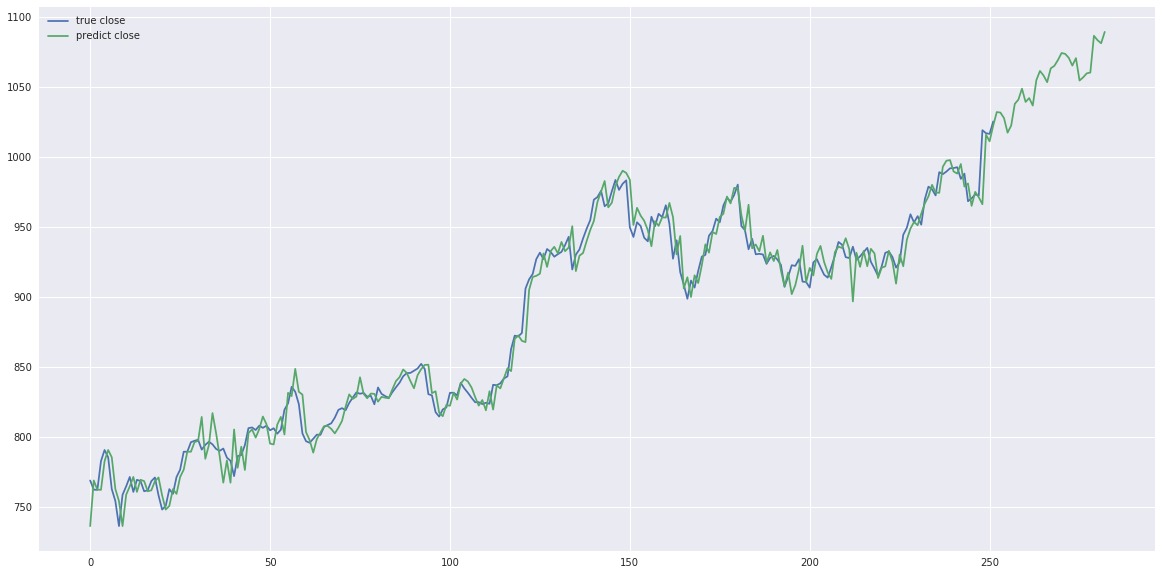

In [7]:
pred = minmax.inverse_transform(pred.predicted_mean.reshape(-1, 1))[:, 0]
plt.figure(figsize = (20, 10))
plt.plot(df.Close, label = 'true close')
plt.plot(pred, label = 'predict close')
plt.legend()
plt.show()

In [8]:
def buy_stock(
    predict_movement,
    real_movement,
    delay = 5,
    initial_state = 1,
    initial_money = 1000,
    max_buy = 3,
    max_sell = 100,
):
    """
    predict_movement = predicted movement
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    delay_change_decision = delay
    current_decision = 0
    state = initial_state
    current_val = pred[0]
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    if state == 1:
        initial_money, current_inventory = buy(
            0, initial_money, current_inventory
        )

    for i in range(1, real_movement.shape[0], 1):
        if predict_movement[i] < current_val and state == 0:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 1
                initial_money, current_inventory = buy(
                    i, initial_money, current_inventory
                )
                current_decision = 0
                states_buy.append(i)
        if predict_movement[i] > current_val and state == 1:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 0

                if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
                else:
                    if current_inventory > max_sell:
                        sell_units = max_sell
                    else:
                        sell_units = current_inventory
                    current_inventory -= sell_units
                    total_sell = sell_units * real_movement[i]
                    initial_money += total_sell
                    try:
                        invest = (
                            (real_movement[i] - real_movement[states_buy[-1]])
                            / real_movement[states_buy[-1]]
                        ) * 100
                    except:
                        invest = 0
                    print(
                        'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                        % (i, sell_units, total_sell, invest, initial_money)
                    )

                current_decision = 0
                states_sell.append(i)
        current_val = pred[i]
    invest = ((initial_money - starting_money) / starting_money) * 100
    print(
        '\ntotal gained %f, total investment %f %%'
        % (initial_money - starting_money, invest)
    )
    plt.figure(figsize = (20, 10))
    plt.plot(df.Close, label = 'true close')
    plt.plot(predict_movement, label = 'predict close')
    plt.plot(
        predict_movement,
        'X',
        label = 'predict buy',
        markevery = states_buy,
        c = 'b',
    )
    plt.plot(
        predict_movement,
        'o',
        label = 'predict sell',
        markevery = states_sell,
        c = 'r',
    )
    plt.legend()
    plt.show()

day 0: buy 3 units at price 2306.100036, total balance 7693.899964
day 11, sell 3 units at price 2313.689940, investment 0.329123 %, total balance 10007.589904,
day 21: buy 3 units at price 2251.500000, total balance 7756.089904
day 27, sell 3 units at price 2367.810060, investment 5.165892 %, total balance 10123.899964,
day 37: buy 3 units at price 2374.649964, total balance 7749.250000
day 45, sell 3 units at price 2419.950072, investment 1.907654 %, total balance 10169.200072,
day 54: buy 3 units at price 2457.929994, total balance 7711.270078
day 65, sell 3 units at price 2420.909913, investment -1.506149 %, total balance 10132.179991,
day 77: buy 3 units at price 2485.920045, total balance 7646.259946
day 86, sell 3 units at price 2516.039979, investment 1.211621 %, total balance 10162.299925,
day 97: buy 3 units at price 2443.289979, total balance 7719.009946
day 109, sell 3 units at price 2470.049928, investment 1.095242 %, total balance 10189.059874,
day 120: buy 3 units at pri

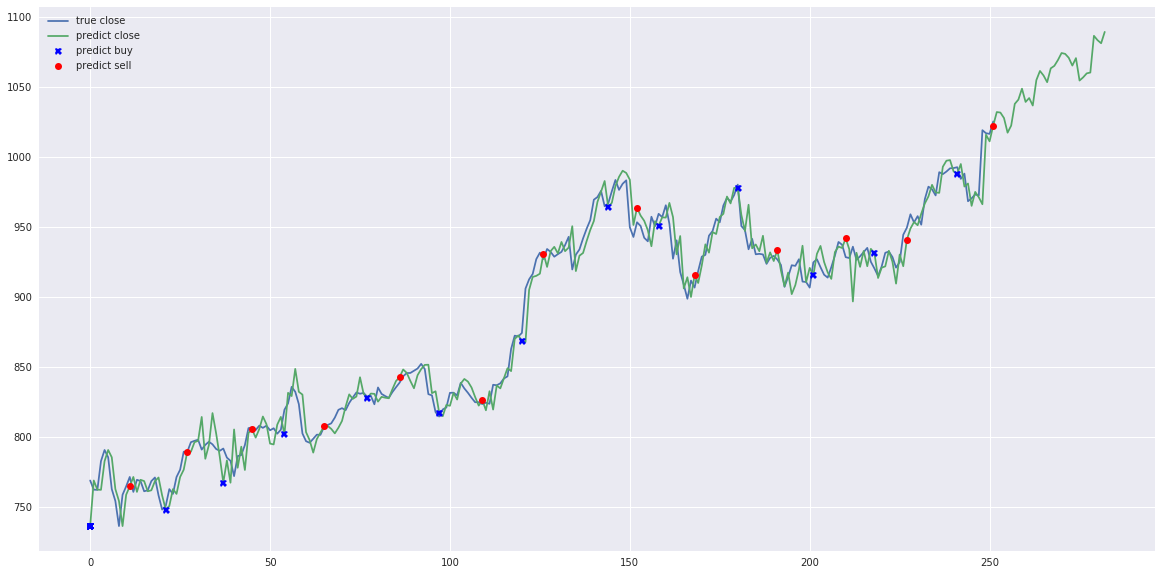

In [9]:
buy_stock(pred, df.Close, initial_state = 1, delay = 4, initial_money = 10000)